In [1]:
from copy import deepcopy
import os
import sys


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.dpi'] = 120

figures_dir = "/Users/matsen/writing/talks/figures/bcr-mut-sel/"
# if this path does not exist, set it to ""
if not os.path.exists(figures_dir):
    figures_dir = ""

# default_font_size = plt.rcParams['font.size']
# plt.rcParams.update({'font.size': default_font_size * 1.4})

In [2]:
compare_df = pd.read_csv("../train/_ignore/model_compare.csv")

# split crepe_basename on "-", the first entry is the model name and the second entry is the train dataset
compare_df["model"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[0])
compare_df["train dataset"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[1])
compare_df = compare_df.drop(columns=["crepe_prefix", "crepe_basename"])
compare_df = compare_df.rename(columns={"dataset_name": "test dataset"})
compare_df = compare_df.sort_values(by=["train dataset", "model"]).reset_index(drop=True)

In [3]:
df = compare_df.copy()

# drop any rows where model matches 4k or 8k
df = df[~df.model.str.contains("4k")]
df = df[~df.model.str.contains("8k")]

# Dictionaries for translation
model_translations = {
    "fivemer": "5mer",
    "rsshmoof": "SHMoof",
    "cnn": "CNN",
    "ind": "Indep",
    "joi": "Joined",
    "hyb": "Hybrid",
    "sml": "Small",
    "med": "Medium",
    "lrg": "Large",
    "4k": "4K"
}

def create_long_name(row):
    parts = row["model"].split('_')
    # Translate each part using the model_translations dictionary
    full_name_parts = [model_translations.get(part, part) for part in parts]
    # Special handling for models without underscores
    if len(full_name_parts) == 1:
        full_name = model_translations.get(row["model"], row["model"])
    else:
        # Join the translated parts with spaces for CNN models
        full_name = ' '.join(full_name_parts[:-1]) + " " + full_name_parts[-1]
    return f"{full_name} ({row['parameter_count']})"

# Apply the transformation to create the long_name column
df['long_name'] = df.apply(create_long_name, axis=1)

# sort df by parameter count
df = df.sort_values(by="parameter_count")
# reverse stable sort by test dataset   
df = df.sort_values(by="test dataset", kind="mergesort")

df.head()

,parameter_count,test dataset,bce_loss,csp_loss,model,train dataset,long_name
34,1082,shmoof_small,0.055764,0.966977,cnn_joi_sml,shmoof_small,CNN Joined Small (1082)
32,1581,shmoof_small,0.055567,0.963625,cnn_joi_med,shmoof_small,CNN Joined Medium (1581)
30,2057,shmoof_small,0.055571,0.959894,cnn_joi_lrg,shmoof_small,CNN Joined Large (2057)
10,2286,shmoof_small,0.055617,0.969388,cnn_hyb_sml,shmoof_small,CNN Hybrid Small (2286)
22,3066,shmoof_small,0.055510,0.968597,cnn_ind_sml,shmoof_small,CNN Indep Small (3066)


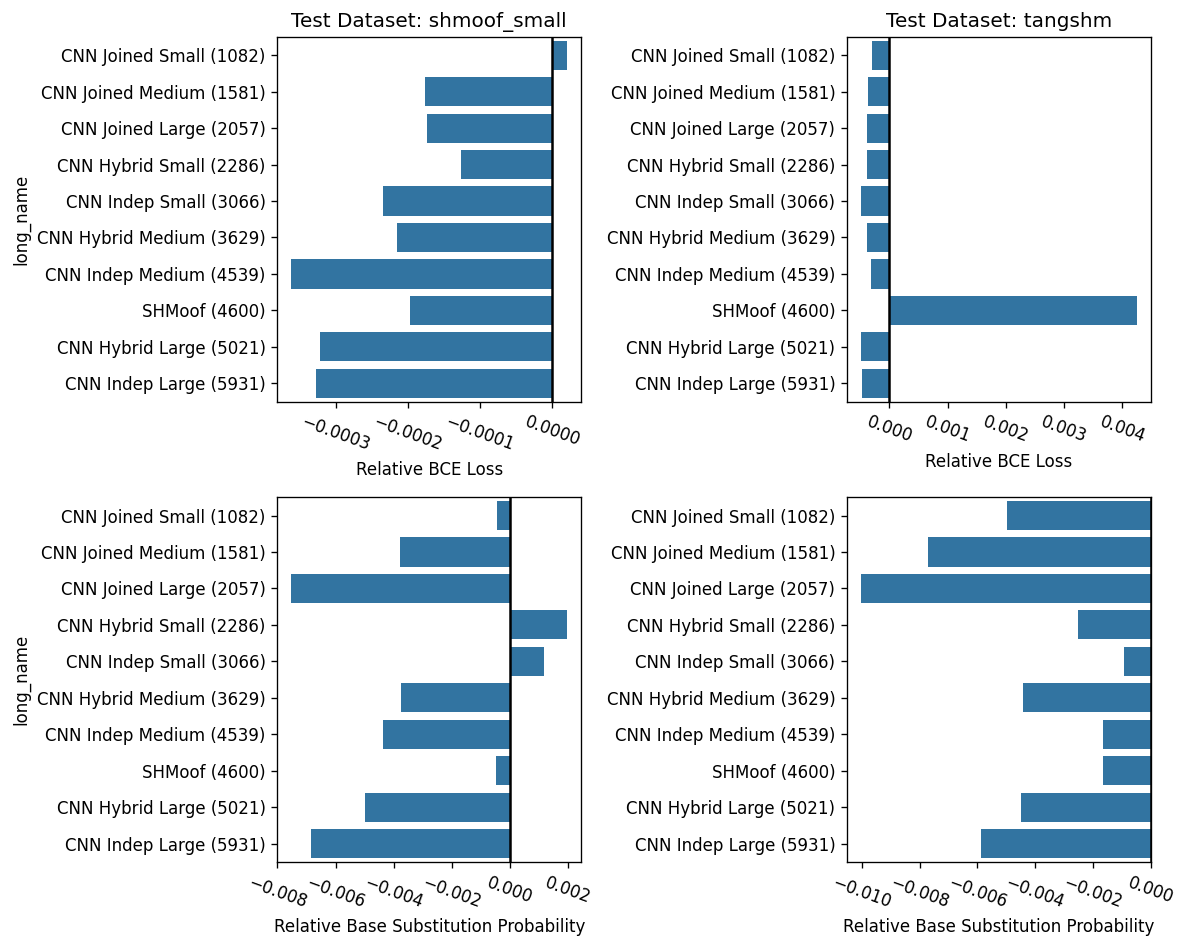

In [4]:
test_datasets = df['test dataset'].unique()

# Adjusted for 2 rows, one for bce_loss and another for csp_loss
fig, axes = plt.subplots(2, len(test_datasets), figsize=(5 * len(test_datasets), 8))

if len(test_datasets) == 1:  # Ensure axes is treated as a 2D array
    axes = np.array([[axes]])

# Calculate relative performance
for test_dataset in test_datasets:
    baseline_bce_loss = df[(df['model'] == 'fivemer') & (df['test dataset'] == test_dataset)]['bce_loss'].values[0]
    baseline_csp_loss = df[(df['model'] == 'fivemer') & (df['test dataset'] == test_dataset)]['csp_loss'].values[0]
    
    df.loc[df['test dataset'] == test_dataset, 'relative_bce_loss'] = df['bce_loss'] - baseline_bce_loss
    df.loc[df['test dataset'] == test_dataset, 'relative_csp_loss'] = df['csp_loss'] - baseline_csp_loss

# drop rows where model is fivemer
df = df[df['model'] != 'fivemer']

for i, test_dataset in enumerate(test_datasets):
    sns.barplot(data=df[df['test dataset'] == test_dataset], x='relative_bce_loss', y='long_name', ax=axes[0, i])
    axes[0, i].set_xlabel('Relative BCE Loss')
    axes[0, i].set_title(f'Test Dataset: {test_dataset}')
    axes[0, i].tick_params(axis='x', rotation=-20)  # Rotate x-tick labels
    
    sns.barplot(data=df[df['test dataset'] == test_dataset], x='relative_csp_loss', y='long_name', ax=axes[1, i])
    axes[1, i].set_xlabel('Relative Base Substitution Probability')
    axes[1, i].tick_params(axis='x', rotation=-20)  # Rotate x-tick labels

# vertical line at x=0
for ax in axes.flatten():
    ax.axvline(x=0, color='k')

# drop y-axis label
for ax in axes[:, 1:].flatten():
    ax.set_ylabel('')

plt.tight_layout()
plt.show()